## Machine Vision Assignment

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,Flatten,BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.losses import SparseCategoricalCrossentropy

import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns


In [61]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num of GPUs available:", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num of GPUs available: 1


### Embeddings from ResNet50

In [62]:
(ds_train, ds_validation,ds_test),ds_info = tfds.load(
    'oxford_iiit_pet',
    split=["train[:90%]", "train[90%:]", "test"], 
    shuffle_files=True,
    as_supervised=True, #[image,label]
    with_info=True)

print("Num training samples-", tf.data.experimental.cardinality(ds_train) )
print("Num val samples-", tf.data.experimental.cardinality(ds_validation) )
print("Num test samples-", tf.data.experimental.cardinality(ds_test) )




Num training samples- tf.Tensor(3312, shape=(), dtype=int64)
Num val samples- tf.Tensor(368, shape=(), dtype=int64)
Num test samples- tf.Tensor(3669, shape=(), dtype=int64)


In [63]:
#full dataset
ds_full = ds_train.concatenate(ds_test).concatenate(ds_validation)
print("Num full samples-", tf.data.experimental.cardinality(ds_full) )


Num full samples- tf.Tensor(7349, shape=(), dtype=int64)


In [64]:
ds_train_initial = ds_train

In [65]:
#resize images
size = (224, 224)

ds_train = ds_train.map(lambda x,y:(tf.image.resize(x,size), y))
ds_validation = ds_validation.map(lambda x,y:(tf.image.resize(x,size), y))
ds_test = ds_test.map(lambda x,y:(tf.image.resize(x,size), y))

ds_full = ds_full.map(lambda x,y:(tf.image.resize(x,size), y))

In [66]:
for i, (image,label) in enumerate(ds_train.take(1)):
    print(image.shape)

(224, 224, 3)


In [67]:
batch_size = 32


ds_train = ds_train.cache().batch(batch_size, drop_remainder=True).prefetch(buffer_size = 10)
ds_validation = ds_validation.cache().batch(batch_size, drop_remainder=True).prefetch(buffer_size = 10)
ds_test = ds_test.cache().batch(batch_size, drop_remainder=True).prefetch(buffer_size = 10)

ds_full = ds_full.cache().batch(batch_size).prefetch(buffer_size = 10)

In [68]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_full))  #full dataset
  

tf.Tensor(103, shape=(), dtype=int64)
tf.Tensor(230, shape=(), dtype=int64)


In [69]:
#import the ResNet50 base model
base_model = keras.applications.ResNet50(
    weights = "imagenet",
    input_shape = (224,224,3),
    pooling = 'avg',
    include_top =False,  #do not include the ImageNet classifier at the top
)

#Freeze the base model
base_model.trainable = False

In [70]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [71]:
base_inputs = base_model.layers[0].input
base_outputs = base_model.layers[-1].output

model = keras.Model(inputs=base_inputs, outputs=base_outputs )

In [72]:
def preprocess(images, labels):
  return tf.keras.applications.resnet50.preprocess_input(images), labels


In [73]:
#train embeddings
ds_train = ds_train.map(preprocess)
train_embeddings = ds_train.map(model)

#validation embeddings
ds_validation = ds_validation.map(preprocess)
val_embeddings = ds_validation.map(model)

#test embeddings
ds_test = ds_test.map(preprocess)
test_embeddings = ds_test.map(model)



In [74]:
#extract labels and images
train_x = ds_train.map(lambda x, y: x)
train_y = ds_train.map(lambda x, y: y)

val_x = ds_validation.map(lambda x, y: x)
val_y = ds_validation.map(lambda x, y: y)

test_x = ds_test.map(lambda x, y: x)
test_y = ds_test.map(lambda x, y: y)

In [75]:
print(train_embeddings)
print(tf.data.experimental.cardinality(train_embeddings) )

<_MapDataset element_spec=TensorSpec(shape=(32, 2048), dtype=tf.float32, name=None)>
tf.Tensor(103, shape=(), dtype=int64)


In [76]:
print(train_x)
print(tf.data.experimental.cardinality(train_x) )

<_MapDataset element_spec=TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None)>
tf.Tensor(103, shape=(), dtype=int64)


In [77]:
print(train_y)
print(tf.data.experimental.cardinality(train_y) )

<_MapDataset element_spec=TensorSpec(shape=(32,), dtype=tf.int64, name=None)>
tf.Tensor(103, shape=(), dtype=int64)


### KNN Classifier

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


In [79]:
train_x_np = np.stack(list(train_embeddings))
train_y_np = np.stack(list(train_y))


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [80]:
print(type(train_x_np), train_x_np.shape)
print(type(train_y_np), train_y_np.shape)

<class 'numpy.ndarray'> (103, 32, 2048)
<class 'numpy.ndarray'> (103, 32)


In [81]:
#train dataset
train_x = train_x_np.reshape((-1, train_x_np.shape[-1]))
train_y = train_y_np.flatten()

In [82]:
print(type(train_x), train_x.shape)
print(type(train_y), train_y.shape)

<class 'numpy.ndarray'> (3296, 2048)
<class 'numpy.ndarray'> (3296,)


In [83]:
#test dataset
test_x_np = np.stack(list(test_embeddings))
test_y_np = np.stack(list(test_y))

test_x = test_x_np.reshape((-1, test_x_np.shape[-1]))
test_y = test_y_np.flatten()

2023-12-12 10:47:46.620917: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


In [84]:
print(type(test_x), test_x.shape)
print(type(test_y), test_y.shape)

<class 'numpy.ndarray'> (3648, 2048)
<class 'numpy.ndarray'> (3648,)


In [85]:
# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(train_x)
X_test = scaler.transform(test_x)


In [89]:
# try K=1 through K=30 and record testing accuracy
k_range = range(1, 31)

# We can create Python dictionary using []
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,  train_y)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(test_y, y_pred))

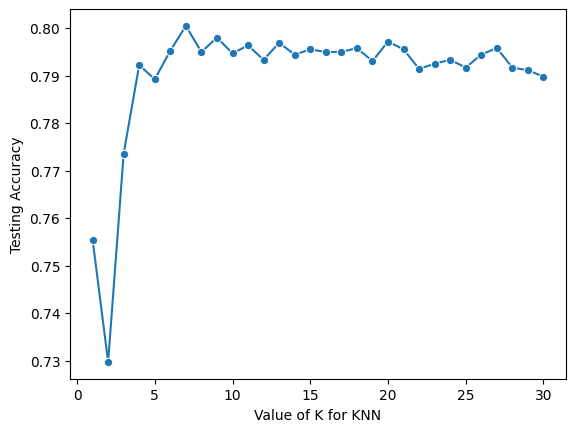

In [90]:
# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
sns.lineplot(x = k_range, y = scores, marker = 'o')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

In [96]:
best_k = k_range[np.argmax(scores)]
print(best_k)
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,  train_y)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(test_y, y_pred)

7


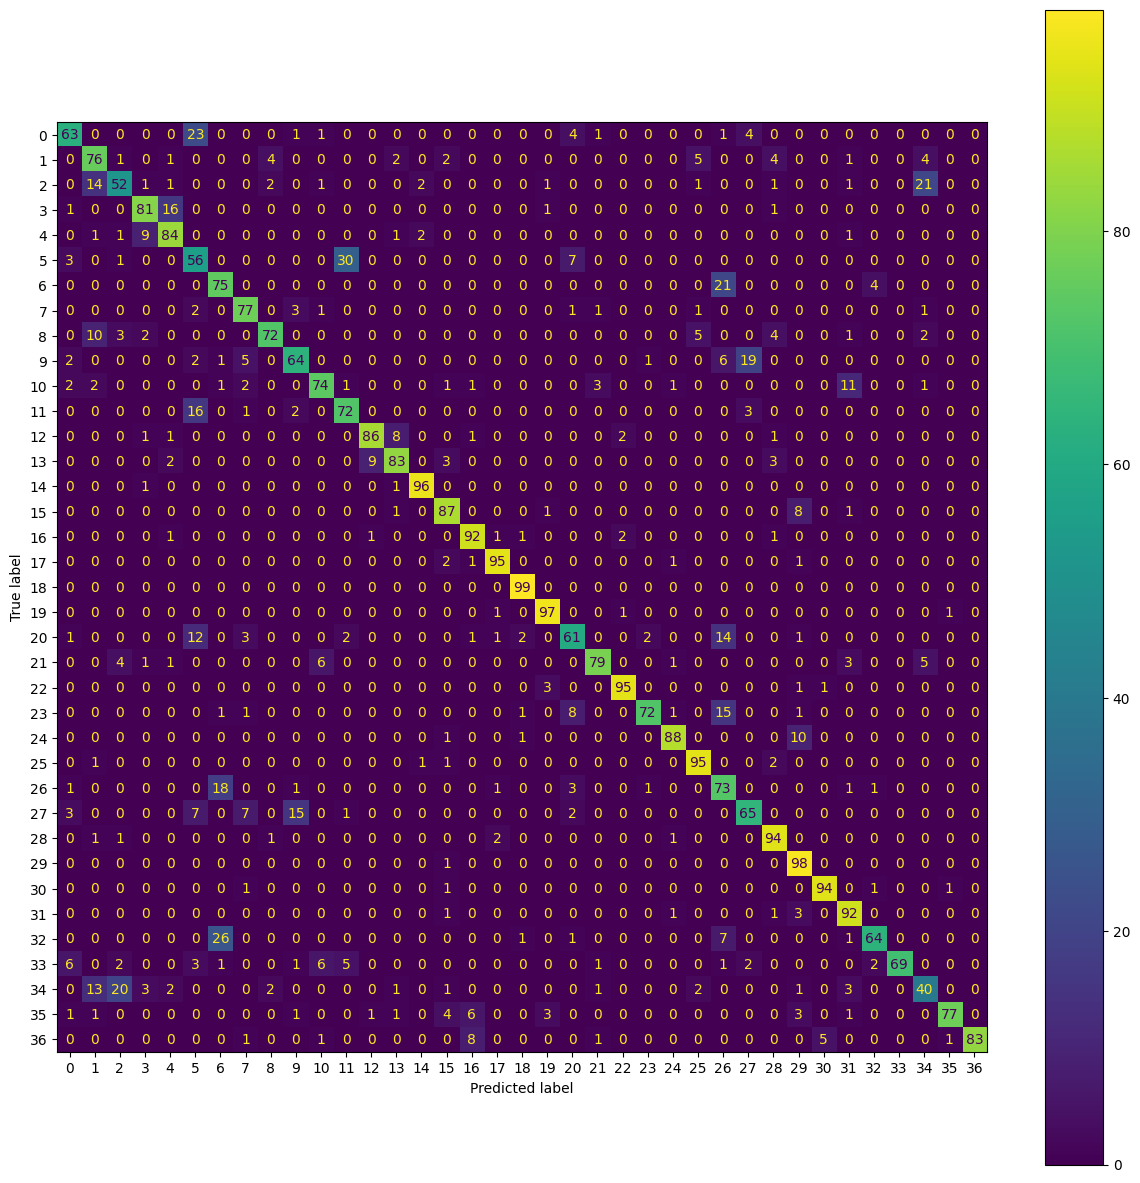

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig,ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(test_y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

In [98]:
# Evaluate the performance
report = classification_report(test_y, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Accuracy: 0.8004385964912281

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.64      0.70        98
           1       0.64      0.76      0.69       100
           2       0.61      0.53      0.57        98
           3       0.82      0.81      0.81       100
           4       0.77      0.85      0.81        99
           5       0.46      0.58      0.51        97
           6       0.61      0.75      0.67       100
           7       0.79      0.89      0.83        87
           8       0.89      0.73      0.80        99
           9       0.73      0.64      0.68       100
          10       0.82      0.74      0.78       100
          11       0.65      0.77      0.70        94
          12       0.89      0.86      0.87       100
          13       0.85      0.83      0.84       100
          14       0.95      0.98      0.96        98
          15       0.83      0.89      0.86        98
          16       0.84    

### Multi-class logistic regression

In [99]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [100]:
#classification head
prediction_layer = tf.keras.layers.Dense(37, activation="softmax")

In [101]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [102]:
#build the model end to end
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = model(x, training=False)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [103]:
#model with classification head
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 model_2 (Functional)        (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 37)                7581

In [106]:
base_learning_rate = 0.005
model.compile(optimizer=SGD(learning_rate= base_learning_rate), 
              loss=SparseCategoricalCrossentropy(), 
              metrics=["accuracy"])

Check this

In [107]:
history = model.fit(ds_train,
                    epochs= 40,
                    validation_data=ds_validation)

Epoch 1/40


2023-12-12 11:40:02.634461: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2023-12-12 11:40:03.045928: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/103 [..............................] - ETA: 13:23 - loss: 4.6051 - accuracy: 0.0000e+00

2023-12-12 11:40:08.277934: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f83b677d6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-12 11:40:08.277957: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
I0000 00:00:1702361408.370764    7873 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


103/103 [==============================] - ETA: 0s - loss: 3.2762 - accuracy: 0.1620

2023-12-12 11:40:25.092172: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 27s 187ms/step - loss: 3.2762 - accuracy: 0.1620 - val_loss: 2.1115 - val_accuracy: 0.4318
Epoch 2/40


2023-12-12 11:40:27.484625: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 18s 170ms/step - loss: 1.9372 - accuracy: 0.4372 - val_loss: 1.4769 - val_accuracy: 0.5852
Epoch 3/40
103/103 [==============================] - 13s 122ms/step - loss: 1.4233 - accuracy: 0.5871 - val_loss: 1.2049 - val_accuracy: 0.6733
Epoch 4/40
103/103 [==============================] - ETA: 0s - loss: 1.1585 - accuracy: 0.6496

2023-12-12 11:41:07.773803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 13s 121ms/step - loss: 1.1585 - accuracy: 0.6496 - val_loss: 1.0658 - val_accuracy: 0.7074
Epoch 5/40
103/103 [==============================] - 11s 107ms/step - loss: 1.0144 - accuracy: 0.6893 - val_loss: 0.9693 - val_accuracy: 0.7386
Epoch 6/40
103/103 [==============================] - ETA: 0s - loss: 0.8923 - accuracy: 0.7424

2023-12-12 11:41:31.860900: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 114ms/step - loss: 0.8923 - accuracy: 0.7424 - val_loss: 0.9074 - val_accuracy: 0.7415
Epoch 7/40
103/103 [==============================] - ETA: 0s - loss: 0.7903 - accuracy: 0.7685

2023-12-12 11:41:43.955799: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 13s 120ms/step - loss: 0.7903 - accuracy: 0.7685 - val_loss: 0.8667 - val_accuracy: 0.7642
Epoch 8/40
103/103 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.7809

2023-12-12 11:41:56.650842: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 112ms/step - loss: 0.7366 - accuracy: 0.7809 - val_loss: 0.8362 - val_accuracy: 0.7528
Epoch 9/40
103/103 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.7952

2023-12-12 11:42:16.985020: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 11s 110ms/step - loss: 0.6984 - accuracy: 0.7952 - val_loss: 0.8167 - val_accuracy: 0.7812
Epoch 10/40
103/103 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.8189

2023-12-12 11:42:28.587188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 111ms/step - loss: 0.6415 - accuracy: 0.8189 - val_loss: 0.7863 - val_accuracy: 0.7841
Epoch 11/40
103/103 [==============================] - 12s 110ms/step - loss: 0.6206 - accuracy: 0.8113 - val_loss: 0.7678 - val_accuracy: 0.7926
Epoch 12/40
103/103 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.8346

2023-12-12 11:42:51.711205: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 111ms/step - loss: 0.5692 - accuracy: 0.8346 - val_loss: 0.7618 - val_accuracy: 0.7869
Epoch 13/40
103/103 [==============================] - 12s 111ms/step - loss: 0.5485 - accuracy: 0.8337 - val_loss: 0.7456 - val_accuracy: 0.7955
Epoch 14/40


2023-12-12 11:43:04.581444: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.8486

2023-12-12 11:43:14.921091: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 111ms/step - loss: 0.5168 - accuracy: 0.8486 - val_loss: 0.7343 - val_accuracy: 0.7926
Epoch 15/40
103/103 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.8565

2023-12-12 11:43:26.773287: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 113ms/step - loss: 0.4972 - accuracy: 0.8565 - val_loss: 0.7281 - val_accuracy: 0.7898
Epoch 16/40
103/103 [==============================] - 12s 111ms/step - loss: 0.4896 - accuracy: 0.8604 - val_loss: 0.7250 - val_accuracy: 0.7898
Epoch 17/40
103/103 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.8592

2023-12-12 11:43:50.084849: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 112ms/step - loss: 0.4712 - accuracy: 0.8592 - val_loss: 0.7055 - val_accuracy: 0.8068
Epoch 18/40
103/103 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.8613

2023-12-12 11:44:01.808050: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 111ms/step - loss: 0.4556 - accuracy: 0.8613 - val_loss: 0.7115 - val_accuracy: 0.7955
Epoch 19/40
103/103 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8729

2023-12-12 11:44:13.646615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 112ms/step - loss: 0.4298 - accuracy: 0.8729 - val_loss: 0.7062 - val_accuracy: 0.7955
Epoch 20/40
103/103 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.8768

2023-12-12 11:44:25.466371: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 113ms/step - loss: 0.4215 - accuracy: 0.8768 - val_loss: 0.6994 - val_accuracy: 0.8011
Epoch 21/40
103/103 [==============================] - 12s 112ms/step - loss: 0.4094 - accuracy: 0.8841 - val_loss: 0.7013 - val_accuracy: 0.7955
Epoch 22/40
103/103 [==============================] - 12s 112ms/step - loss: 0.3875 - accuracy: 0.8880 - val_loss: 0.6948 - val_accuracy: 0.8011
Epoch 23/40


2023-12-12 11:44:50.200978: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 114ms/step - loss: 0.3724 - accuracy: 0.8975 - val_loss: 0.6960 - val_accuracy: 0.8011
Epoch 24/40
103/103 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8978

2023-12-12 11:45:12.623833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 112ms/step - loss: 0.3703 - accuracy: 0.8978 - val_loss: 0.6794 - val_accuracy: 0.8040
Epoch 25/40
103/103 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8996

2023-12-12 11:45:24.566466: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 113ms/step - loss: 0.3616 - accuracy: 0.8996 - val_loss: 0.6941 - val_accuracy: 0.7983
Epoch 26/40
103/103 [==============================] - 12s 113ms/step - loss: 0.3518 - accuracy: 0.9044 - val_loss: 0.6832 - val_accuracy: 0.8097
Epoch 27/40
103/103 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.9014

2023-12-12 11:45:48.257311: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 114ms/step - loss: 0.3448 - accuracy: 0.9014 - val_loss: 0.6861 - val_accuracy: 0.8068
Epoch 28/40


2023-12-12 11:45:49.557211: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 114ms/step - loss: 0.3391 - accuracy: 0.9056 - val_loss: 0.6773 - val_accuracy: 0.8153
Epoch 29/40
103/103 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.9132

2023-12-12 11:46:12.197126: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 114ms/step - loss: 0.3165 - accuracy: 0.9132 - val_loss: 0.6775 - val_accuracy: 0.8040
Epoch 30/40
103/103 [==============================] - 12s 110ms/step - loss: 0.3177 - accuracy: 0.9141 - val_loss: 0.6725 - val_accuracy: 0.8011
Epoch 31/40
103/103 [==============================] - 12s 111ms/step - loss: 0.3143 - accuracy: 0.9093 - val_loss: 0.6772 - val_accuracy: 0.8097
Epoch 32/40
103/103 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.9199

2023-12-12 11:46:55.815076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 113ms/step - loss: 0.3039 - accuracy: 0.9199 - val_loss: 0.6816 - val_accuracy: 0.8097
Epoch 33/40
103/103 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.9257

2023-12-12 11:47:07.655824: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 113ms/step - loss: 0.2818 - accuracy: 0.9257 - val_loss: 0.6748 - val_accuracy: 0.8068
Epoch 34/40
103/103 [==============================] - 12s 113ms/step - loss: 0.2929 - accuracy: 0.9190 - val_loss: 0.6773 - val_accuracy: 0.8040
Epoch 35/40
103/103 [==============================] - 12s 114ms/step - loss: 0.2806 - accuracy: 0.9287 - val_loss: 0.6665 - val_accuracy: 0.7955
Epoch 36/40
103/103 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.9281

2023-12-12 11:47:43.446568: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 115ms/step - loss: 0.2773 - accuracy: 0.9281 - val_loss: 0.6658 - val_accuracy: 0.8068
Epoch 37/40


2023-12-12 11:47:44.747159: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.9320

2023-12-12 11:47:55.426008: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 114ms/step - loss: 0.2663 - accuracy: 0.9320 - val_loss: 0.6711 - val_accuracy: 0.8068
Epoch 38/40
103/103 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.9351

2023-12-12 11:48:07.459900: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 115ms/step - loss: 0.2589 - accuracy: 0.9351 - val_loss: 0.6773 - val_accuracy: 0.8125
Epoch 39/40
103/103 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9357

2023-12-12 11:48:19.472665: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 12s 114ms/step - loss: 0.2543 - accuracy: 0.9357 - val_loss: 0.6639 - val_accuracy: 0.8097
Epoch 40/40
103/103 [==============================] - 12s 115ms/step - loss: 0.2626 - accuracy: 0.9302 - val_loss: 0.6646 - val_accuracy: 0.8153


In [108]:
loss, accuracy = model.evaluate(ds_test)
print('Test accuracy of regression model:', accuracy)

114/114 [==============================] - 11s 97ms/step - loss: 0.6972 - accuracy: 0.7807
Test accuracy of regression model: 0.780701756477356


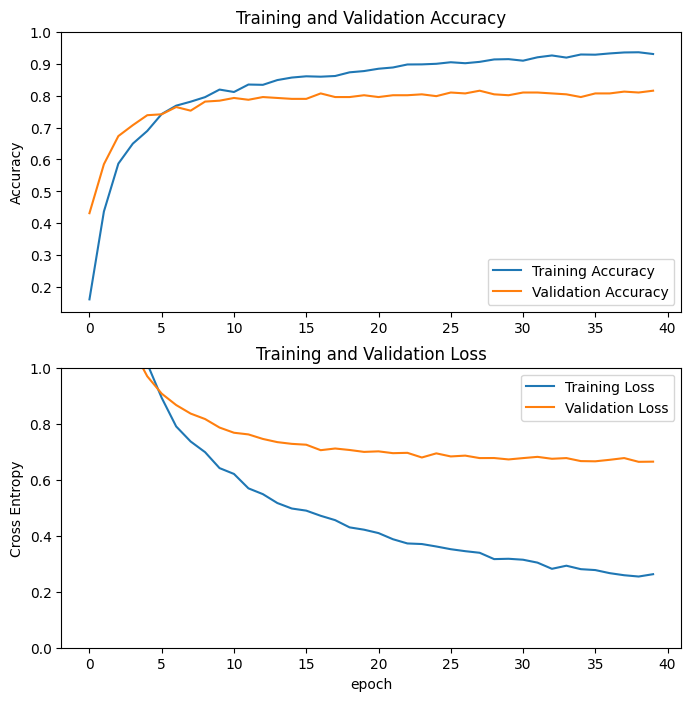

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Issues with the validation loss

### Fine Tuning

In [110]:
#using data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [118]:
#model with data augmentation and dropout
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [119]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0   

In [120]:
#for fine tuning
model.trainable = True

In [121]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  176


In [122]:
model.compile(optimizer=SGD(learning_rate= base_learning_rate/10), 
              loss=SparseCategoricalCrossentropy(), 
              metrics=["accuracy"])

In [123]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0   

In [124]:
history_fine = model.fit(ds_train,
                         epochs=40,
                         validation_data=ds_validation)

Epoch 1/40


  1/103 [..............................] - ETA: 11:26 - loss: 0.8615 - accuracy: 0.7188

2023-12-12 11:51:37.442834: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-12 11:51:37.442880: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-12 11:51:37.458136: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-12 11:51:37.458178: W external/local_tsl/tsl/framework/bfc_

103/103 [==============================] - ETA: 0s - loss: 0.8411 - accuracy: 0.7382

2023-12-12 11:51:54.505851: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 25s 177ms/step - loss: 0.8411 - accuracy: 0.7382 - val_loss: 0.6574 - val_accuracy: 0.8040
Epoch 2/40
103/103 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.7549

2023-12-12 11:52:09.887576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 15s 148ms/step - loss: 0.7529 - accuracy: 0.7549 - val_loss: 0.6491 - val_accuracy: 0.8068
Epoch 3/40
103/103 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.7746

2023-12-12 11:52:26.056161: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 16s 155ms/step - loss: 0.6810 - accuracy: 0.7746 - val_loss: 0.6540 - val_accuracy: 0.8125
Epoch 4/40
103/103 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.7755

2023-12-12 11:52:42.226302: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 16s 156ms/step - loss: 0.6853 - accuracy: 0.7755 - val_loss: 0.6396 - val_accuracy: 0.8153
Epoch 5/40
103/103 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.7916

2023-12-12 11:52:58.647080: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 159ms/step - loss: 0.6493 - accuracy: 0.7916 - val_loss: 0.6539 - val_accuracy: 0.8267
Epoch 6/40
103/103 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.7964

2023-12-12 11:53:15.313248: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 164ms/step - loss: 0.6376 - accuracy: 0.7964 - val_loss: 0.6245 - val_accuracy: 0.8267
Epoch 7/40
103/103 [==============================] - ETA: 0s - loss: 0.5838 - accuracy: 0.8092

2023-12-12 11:53:32.158314: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 16s 156ms/step - loss: 0.5838 - accuracy: 0.8092 - val_loss: 0.6419 - val_accuracy: 0.8267
Epoch 8/40
103/103 [==============================] - ETA: 0s - loss: 0.5513 - accuracy: 0.8125

2023-12-12 11:53:48.676178: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 162ms/step - loss: 0.5513 - accuracy: 0.8125 - val_loss: 0.6374 - val_accuracy: 0.8267
Epoch 9/40
103/103 [==============================] - ETA: 0s - loss: 0.5471 - accuracy: 0.8189

2023-12-12 11:54:05.809091: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 160ms/step - loss: 0.5471 - accuracy: 0.8189 - val_loss: 0.6308 - val_accuracy: 0.8267
Epoch 10/40
103/103 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.8158

2023-12-12 11:54:22.748751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 18s 174ms/step - loss: 0.5466 - accuracy: 0.8158 - val_loss: 0.6228 - val_accuracy: 0.8239
Epoch 11/40
103/103 [==============================] - ETA: 0s - loss: 0.5178 - accuracy: 0.8243

2023-12-12 11:54:40.838208: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 161ms/step - loss: 0.5178 - accuracy: 0.8243 - val_loss: 0.6198 - val_accuracy: 0.8239
Epoch 12/40
103/103 [==============================] - 17s 163ms/step - loss: 0.5109 - accuracy: 0.8310 - val_loss: 0.6197 - val_accuracy: 0.8352
Epoch 13/40
103/103 [==============================] - ETA: 0s - loss: 0.4753 - accuracy: 0.8407

2023-12-12 11:55:15.033971: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 164ms/step - loss: 0.4753 - accuracy: 0.8407 - val_loss: 0.6180 - val_accuracy: 0.8295
Epoch 14/40
103/103 [==============================] - 17s 162ms/step - loss: 0.4765 - accuracy: 0.8407 - val_loss: 0.6174 - val_accuracy: 0.8352
Epoch 15/40
103/103 [==============================] - 17s 164ms/step - loss: 0.4549 - accuracy: 0.8453 - val_loss: 0.6180 - val_accuracy: 0.8295
Epoch 16/40
103/103 [==============================] - 17s 165ms/step - loss: 0.4741 - accuracy: 0.8447 - val_loss: 0.5973 - val_accuracy: 0.8438
Epoch 17/40
103/103 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8529

2023-12-12 11:56:27.038710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 18s 178ms/step - loss: 0.4397 - accuracy: 0.8529 - val_loss: 0.6097 - val_accuracy: 0.8381
Epoch 18/40
103/103 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.8629

2023-12-12 11:56:45.365785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 164ms/step - loss: 0.4160 - accuracy: 0.8629 - val_loss: 0.6135 - val_accuracy: 0.8295
Epoch 19/40
103/103 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8644

2023-12-12 11:57:02.500312: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 164ms/step - loss: 0.4052 - accuracy: 0.8644 - val_loss: 0.6074 - val_accuracy: 0.8352
Epoch 20/40
103/103 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.8626

2023-12-12 11:57:19.477345: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 164ms/step - loss: 0.4101 - accuracy: 0.8626 - val_loss: 0.6244 - val_accuracy: 0.8295
Epoch 21/40
103/103 [==============================] - ETA: 0s - loss: 0.4002 - accuracy: 0.8653

2023-12-12 11:57:36.471363: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 18s 175ms/step - loss: 0.4002 - accuracy: 0.8653 - val_loss: 0.6217 - val_accuracy: 0.8182
Epoch 22/40
103/103 [==============================] - ETA: 0s - loss: 0.3686 - accuracy: 0.8765

2023-12-12 11:57:54.552525: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 161ms/step - loss: 0.3686 - accuracy: 0.8765 - val_loss: 0.6166 - val_accuracy: 0.8295
Epoch 23/40
103/103 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.8644

2023-12-12 11:58:14.742352: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 158ms/step - loss: 0.3919 - accuracy: 0.8644 - val_loss: 0.6098 - val_accuracy: 0.8352
Epoch 24/40
103/103 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.8756

2023-12-12 11:58:31.777913: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 163ms/step - loss: 0.3756 - accuracy: 0.8756 - val_loss: 0.6024 - val_accuracy: 0.8267
Epoch 25/40
103/103 [==============================] - 17s 164ms/step - loss: 0.3506 - accuracy: 0.8786 - val_loss: 0.6030 - val_accuracy: 0.8409
Epoch 26/40
103/103 [==============================] - 17s 166ms/step - loss: 0.3360 - accuracy: 0.8883 - val_loss: 0.6168 - val_accuracy: 0.8295
Epoch 27/40
103/103 [==============================] - 17s 165ms/step - loss: 0.3360 - accuracy: 0.8905 - val_loss: 0.6276 - val_accuracy: 0.8352
Epoch 28/40
103/103 [==============================] - 17s 165ms/step - loss: 0.3301 - accuracy: 0.8911 - val_loss: 0.6092 - val_accuracy: 0.8295
Epoch 29/40
103/103 [==============================] - 17s 166ms/step - loss: 0.3271 - accuracy: 0.8917 - val_loss: 0.6196 - val_accuracy: 0.8267
Epoch 30/40
103/103 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8956

2023-12-12 12:00:15.156465: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 165ms/step - loss: 0.3116 - accuracy: 0.8956 - val_loss: 0.6227 - val_accuracy: 0.8295
Epoch 31/40
103/103 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.8993

2023-12-12 12:00:32.557299: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 167ms/step - loss: 0.3041 - accuracy: 0.8993 - val_loss: 0.6408 - val_accuracy: 0.8324
Epoch 32/40
103/103 [==============================] - 17s 166ms/step - loss: 0.2931 - accuracy: 0.9029 - val_loss: 0.6357 - val_accuracy: 0.8352
Epoch 33/40
103/103 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.9044

2023-12-12 12:01:07.430086: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 167ms/step - loss: 0.2858 - accuracy: 0.9044 - val_loss: 0.6320 - val_accuracy: 0.8409
Epoch 34/40
103/103 [==============================] - 17s 166ms/step - loss: 0.3193 - accuracy: 0.8926 - val_loss: 0.6137 - val_accuracy: 0.8438
Epoch 35/40
103/103 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.9020

2023-12-12 12:01:41.946576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 165ms/step - loss: 0.2874 - accuracy: 0.9020 - val_loss: 0.6327 - val_accuracy: 0.8381
Epoch 36/40
103/103 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.9078

2023-12-12 12:01:59.357487: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 192678400 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/103 [==============================] - 17s 167ms/step - loss: 0.2654 - accuracy: 0.9078 - val_loss: 0.6143 - val_accuracy: 0.8409
Epoch 37/40
103/103 [==============================] - 17s 162ms/step - loss: 0.2491 - accuracy: 0.9169 - val_loss: 0.6359 - val_accuracy: 0.8352
Epoch 38/40
103/103 [==============================] - 17s 165ms/step - loss: 0.2594 - accuracy: 0.9117 - val_loss: 0.6222 - val_accuracy: 0.8324
Epoch 39/40
103/103 [==============================] - 17s 165ms/step - loss: 0.2345 - accuracy: 0.9238 - val_loss: 0.6512 - val_accuracy: 0.8409
Epoch 40/40
103/103 [==============================] - 17s 164ms/step - loss: 0.2666 - accuracy: 0.9129 - val_loss: 0.6130 - val_accuracy: 0.8466


In [125]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

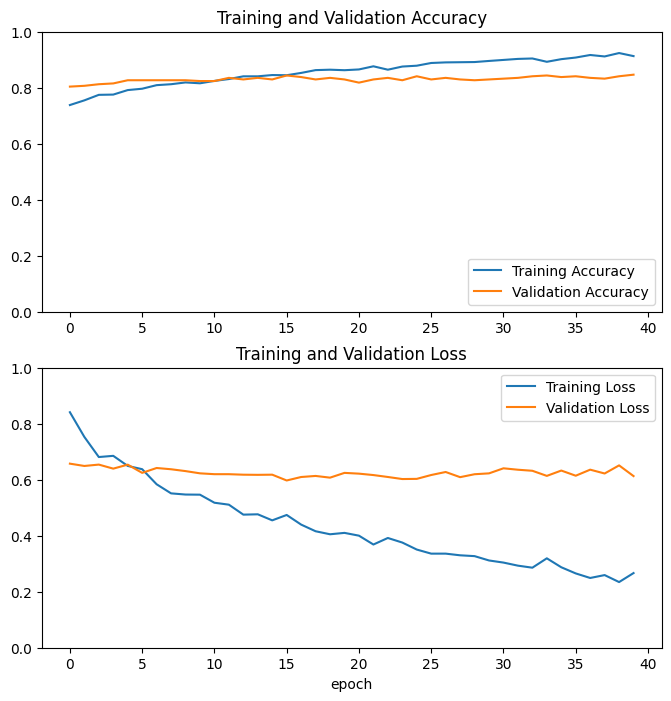

In [127]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [128]:
loss, accuracy = model.evaluate(ds_test)
print('Test accuracy :', accuracy)

114/114 [==============================] - 11s 93ms/step - loss: 0.6725 - accuracy: 0.8084
Test accuracy : 0.8083881735801697
